Imports

In [1]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import os

Device

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Plot functions

In [3]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

Class to manage configuration

In [4]:
class Config():
    training_dir = "images/training" #path to the training directory
    testing_dir =  "images/testing" #path to the testing directory
    train_batch_size = 64

Generates image pairs --> 0 for geniune pair and 1 for imposter pair

In [5]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break
        
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [6]:
folder_dataset = dset.ImageFolder(root=Config.training_dir) #training dataset


Custom datasets

In [7]:
siamese_dataset_128x128_10 = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((128, 128)),
                                                                      transforms.ToTensor()
                                                                      ]) ,should_invert=False)

siamese_dataset_32x32_10 = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((32,32)),
                                                                      transforms.ToTensor()
                                                                      ]) ,should_invert=False)

Train dataloaders

In [8]:
train_dataloader_128x128_10 = DataLoader(siamese_dataset_128x128_10,
                        shuffle=True,
                        batch_size=Config.train_batch_size)

train_dataloader_32x32_10 = DataLoader(siamese_dataset_32x32_10,
                        shuffle=True,
                        batch_size=Config.train_batch_size)

Visualization image pairs --> 1 indiciates dissimilar, and 0 indicates similar

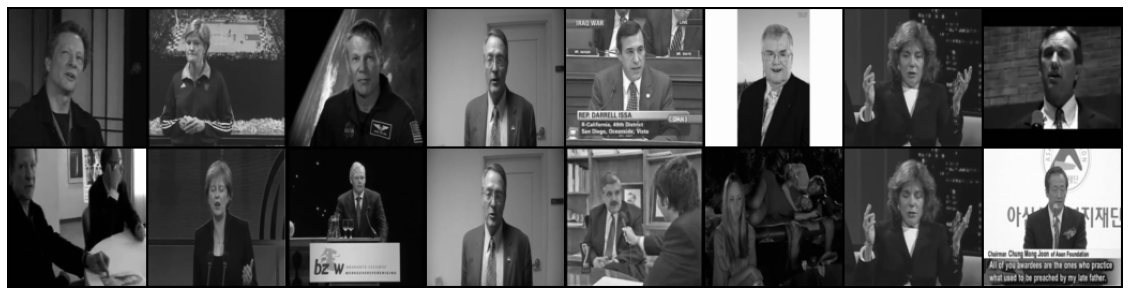

[0. 1. 1. 0. 1. 1. 0. 1.]


In [9]:
vis_dataloader = DataLoader(siamese_dataset_128x128_10,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8
)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
plt.figure(figsize=[20, 20])
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

Siamese models

In [10]:
class SiameseNetwork128x128(nn.Module):
    def __init__(self):
        super(SiameseNetwork128x128, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels= 1, out_channels=96, kernel_size=(11,11), stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (3,3), stride=2),
            
            nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size=(5,5), stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (3,3), stride=2),
            nn.Dropout2d(p= 0.3),

            nn.Conv2d(in_channels = 256, out_channels =384, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels =384, out_channels= 256, kernel_size=(3,3), stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(3,3), stride=2),
            nn.Dropout2d(p=0.3)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features =43264, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),

            nn.Linear(in_features=1024, out_features=128),
            nn.ReLU(inplace=True),

            nn.Linear(in_features=128, out_features=15),
            nn.Sigmoid())

    #2 forward functions

    def forward_once(self, x):
        output = self.cnn1(x).cuda()
        output = output.view(output.size()[0], -1).cuda()
        output = self.fc1(output).cuda()
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1).cuda()
        output2 = self.forward_once(input2).cuda()
        return output1, output2

In [12]:
class SiameseNetwork32x32(nn.Module):
    def __init__(self):
        super(SiameseNetwork32x32, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels= 1, out_channels=96, kernel_size=(11,11), stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (3,3), stride=2),
            
            nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size=(5,5), stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (3,3), stride=2),
            nn.Dropout2d(p= 0.3),

            nn.Conv2d(in_channels = 256, out_channels =384, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels =384, out_channels= 256, kernel_size=(3,3), stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(3,3), stride=2),
            nn.Dropout2d(p=0.3)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features =256, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),

            nn.Linear(in_features=1024, out_features=128),
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=128, out_features=15),
            nn.Sigmoid())

    #2 forward functions

    def forward_once(self, x):
        output = self.cnn1(x).cuda()
        output = output.view(output.size()[0], -1).cuda()
        output = self.fc1(output).cuda()
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1).cuda()
        output2 = self.forward_once(input2).cuda()
        return output1, output2

Loss function

In [13]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

Train function

In [14]:
def train(device, siamese_model, epochs, optimizer, loss_function, train_dataloader, save):
    counter = []
    loss_history = [] 
    iteration_number= 0
    best_loss = 100
    for epoch in tqdm(range(0,epochs)):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data #data is 2 images and a label
            
            img0, img1 , label = img0.to(device), img1.to(device), label.to(device) #push to gpu
            
            optimizer.zero_grad() #zero gradients for every batch
            
            output1,output2 = siamese_model(img0,img1) #pass 2 images in the network and obtain two outputs
            
            loss = loss_function(output1,output2,label) #compute loss for both outputs and the label
            
            loss.backward() #compute gradients
            
            optimizer.step() #adjust learning weights
            
            if i %len(train_dataloader) == 0 : #gather data and report progress
                print("Epoch number {}: Current loss {}".format(epoch, loss.item()))
                if loss.item() < best_loss:
                    torch.save(siamese_model.state_dict(), save)
                    best_loss = loss.item()
                    
                iteration_number +=1
                counter.append(iteration_number)
                loss_history.append(loss.item())

    show_plot(counter,loss_history)

In [15]:
siamese_model128x128 = SiameseNetwork128x128().to(device)
siamese_model32x32 = SiameseNetwork32x32().to(device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch number 0: Current loss 2.3625824451446533


  7%|▋         | 1/15 [00:41<09:35, 41.10s/it]

Epoch number 1: Current loss 0.8673990368843079


 13%|█▎        | 2/15 [01:15<08:05, 37.35s/it]

Epoch number 2: Current loss 0.6363039016723633


 20%|██        | 3/15 [01:49<07:10, 35.83s/it]

Epoch number 3: Current loss 0.5178186893463135


 27%|██▋       | 4/15 [02:23<06:22, 34.80s/it]

Epoch number 4: Current loss 0.7125913500785828


 33%|███▎      | 5/15 [02:55<05:40, 34.07s/it]

Epoch number 5: Current loss 0.7495325803756714


 40%|████      | 6/15 [03:28<05:01, 33.55s/it]

Epoch number 6: Current loss 0.741152286529541


 47%|████▋     | 7/15 [04:00<04:25, 33.20s/it]

Epoch number 7: Current loss 0.813573956489563


 53%|█████▎    | 8/15 [04:33<03:50, 32.95s/it]

Epoch number 8: Current loss 0.9097113609313965


 60%|██████    | 9/15 [05:05<03:16, 32.75s/it]

Epoch number 9: Current loss 0.704423725605011


 67%|██████▋   | 10/15 [05:37<02:42, 32.53s/it]

Epoch number 10: Current loss 0.6391283273696899


 73%|███████▎  | 11/15 [06:09<02:09, 32.41s/it]

Epoch number 11: Current loss 0.8152395486831665


 80%|████████  | 12/15 [06:41<01:36, 32.19s/it]

Epoch number 12: Current loss 0.7556574940681458


 87%|████████▋ | 13/15 [07:13<01:04, 32.17s/it]

Epoch number 13: Current loss 0.7796293497085571


 93%|█████████▎| 14/15 [07:45<00:32, 32.21s/it]

Epoch number 14: Current loss 0.8313886523246765


100%|██████████| 15/15 [08:19<00:00, 33.32s/it]


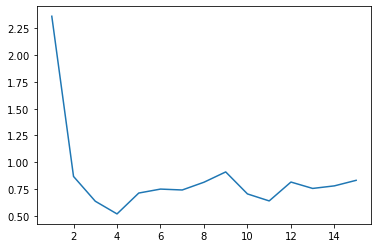

In [16]:
network128x128 = train(device, siamese_model128x128, 15, optim.Adam(siamese_model128x128.parameters()) , ContrastiveLoss(), train_dataloader_128x128_10, 'savepath/128x128.pth' )

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch number 0: Current loss 1.9197771549224854


  7%|▋         | 1/15 [00:26<06:07, 26.28s/it]

Epoch number 1: Current loss 0.9104955196380615


 13%|█▎        | 2/15 [00:52<05:42, 26.32s/it]

Epoch number 2: Current loss 1.0491364002227783


 20%|██        | 3/15 [01:18<05:15, 26.30s/it]

Epoch number 3: Current loss 0.8849301934242249


 27%|██▋       | 4/15 [01:46<04:56, 26.95s/it]

Epoch number 4: Current loss 0.9537389278411865


 33%|███▎      | 5/15 [02:13<04:27, 26.73s/it]

Epoch number 5: Current loss 0.7426144480705261


 40%|████      | 6/15 [02:39<03:59, 26.64s/it]

Epoch number 6: Current loss 0.8685811161994934


 47%|████▋     | 7/15 [03:06<03:32, 26.56s/it]

Epoch number 7: Current loss 0.799474835395813


 53%|█████▎    | 8/15 [03:32<03:05, 26.54s/it]

Epoch number 8: Current loss 0.7606146335601807


 60%|██████    | 9/15 [03:59<02:39, 26.57s/it]

Epoch number 9: Current loss 0.8564359545707703


 67%|██████▋   | 10/15 [04:25<02:12, 26.57s/it]

Epoch number 10: Current loss 0.8416293859481812


 73%|███████▎  | 11/15 [04:52<01:46, 26.53s/it]

Epoch number 11: Current loss 0.8125599026679993


 80%|████████  | 12/15 [05:18<01:19, 26.52s/it]

Epoch number 12: Current loss 0.7990578413009644


 87%|████████▋ | 13/15 [05:44<00:52, 26.34s/it]

Epoch number 13: Current loss 0.7245020866394043


 93%|█████████▎| 14/15 [06:10<00:26, 26.09s/it]

Epoch number 14: Current loss 0.7748131155967712


100%|██████████| 15/15 [06:35<00:00, 26.36s/it]


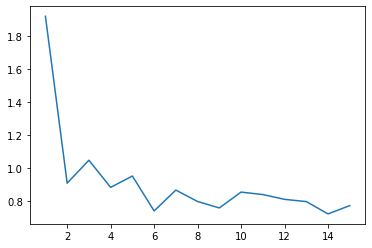

In [18]:
network32x32 = train(device, siamese_model32x32, 15, optim.Adam(siamese_model32x32.parameters()) , ContrastiveLoss(), train_dataloader_32x32_10, 'savepath/32x32.pth' )